# Using cadences

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
from astropy.time import Time
import scipy

import setigen as stg

In [2]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In `setigen`, cadences are used to organize frames and facilitate signal injection. The `Cadence` object itself is a `MutableSequence`, which allows you to append frames and use slices to select specific frames. 

In [3]:
c = stg.Cadence()

Cadences can be filled with both synthetic and real observations frames. For synthetic frames, you'll need to specify the starting `mjd` or `t_start` in Unix time. Otherwise, it will default to the actual machine time in which the frame was created. Note that within a `Frame` object, times are stored in Unix format for computation. 

Let's make a purely synthetic cadence. First, we create an array of start times to use:

In [4]:
mjd_start = 56789
obs_length = 300
slew_time = 15

t_start_arr = [Time(mjd_start, format='mjd').unix]
for i in range(1, 6):
    t_start_arr.append(t_start_arr[i - 1] + obs_length + slew_time)

Then, we create empty frames, add synthetic chi-squared noise, and append each frame to the cadence. If we were using real observations, we would just create frames using observational data on file and append to the cadence in the same way.

In [5]:
# Arbitrary value to set noise background
noise_mean = 5.5e6

for i in range(6):
    if i % 2 == 0:
        source_name = 'ON'
    else:
        source_name = f'OFF{(i + 1) // 2}'
    frame = stg.Frame(fchans=512,
                      tchans=16,
                      df=2.7939677238464355,
                      dt=18.253611008,
                      fch1=6000*u.MHz,
                      ascending=False,
                      t_start=t_start_arr[i],
                      source_name=source_name)
    frame.add_noise(noise_mean)
    c.append(frame)
print(c)

[<setigen.frame.Frame object at 0x7fe0dccaf290>, <setigen.frame.Frame object at 0x7fe0dccaf3d0>, <setigen.frame.Frame object at 0x7fe0dcca2850>, <setigen.frame.Frame object at 0x7fe0dccaf4d0>, <setigen.frame.Frame object at 0x7fe0dccaf510>, <setigen.frame.Frame object at 0x7fe0dccaf690>]


To visualize the current frames, we can run:

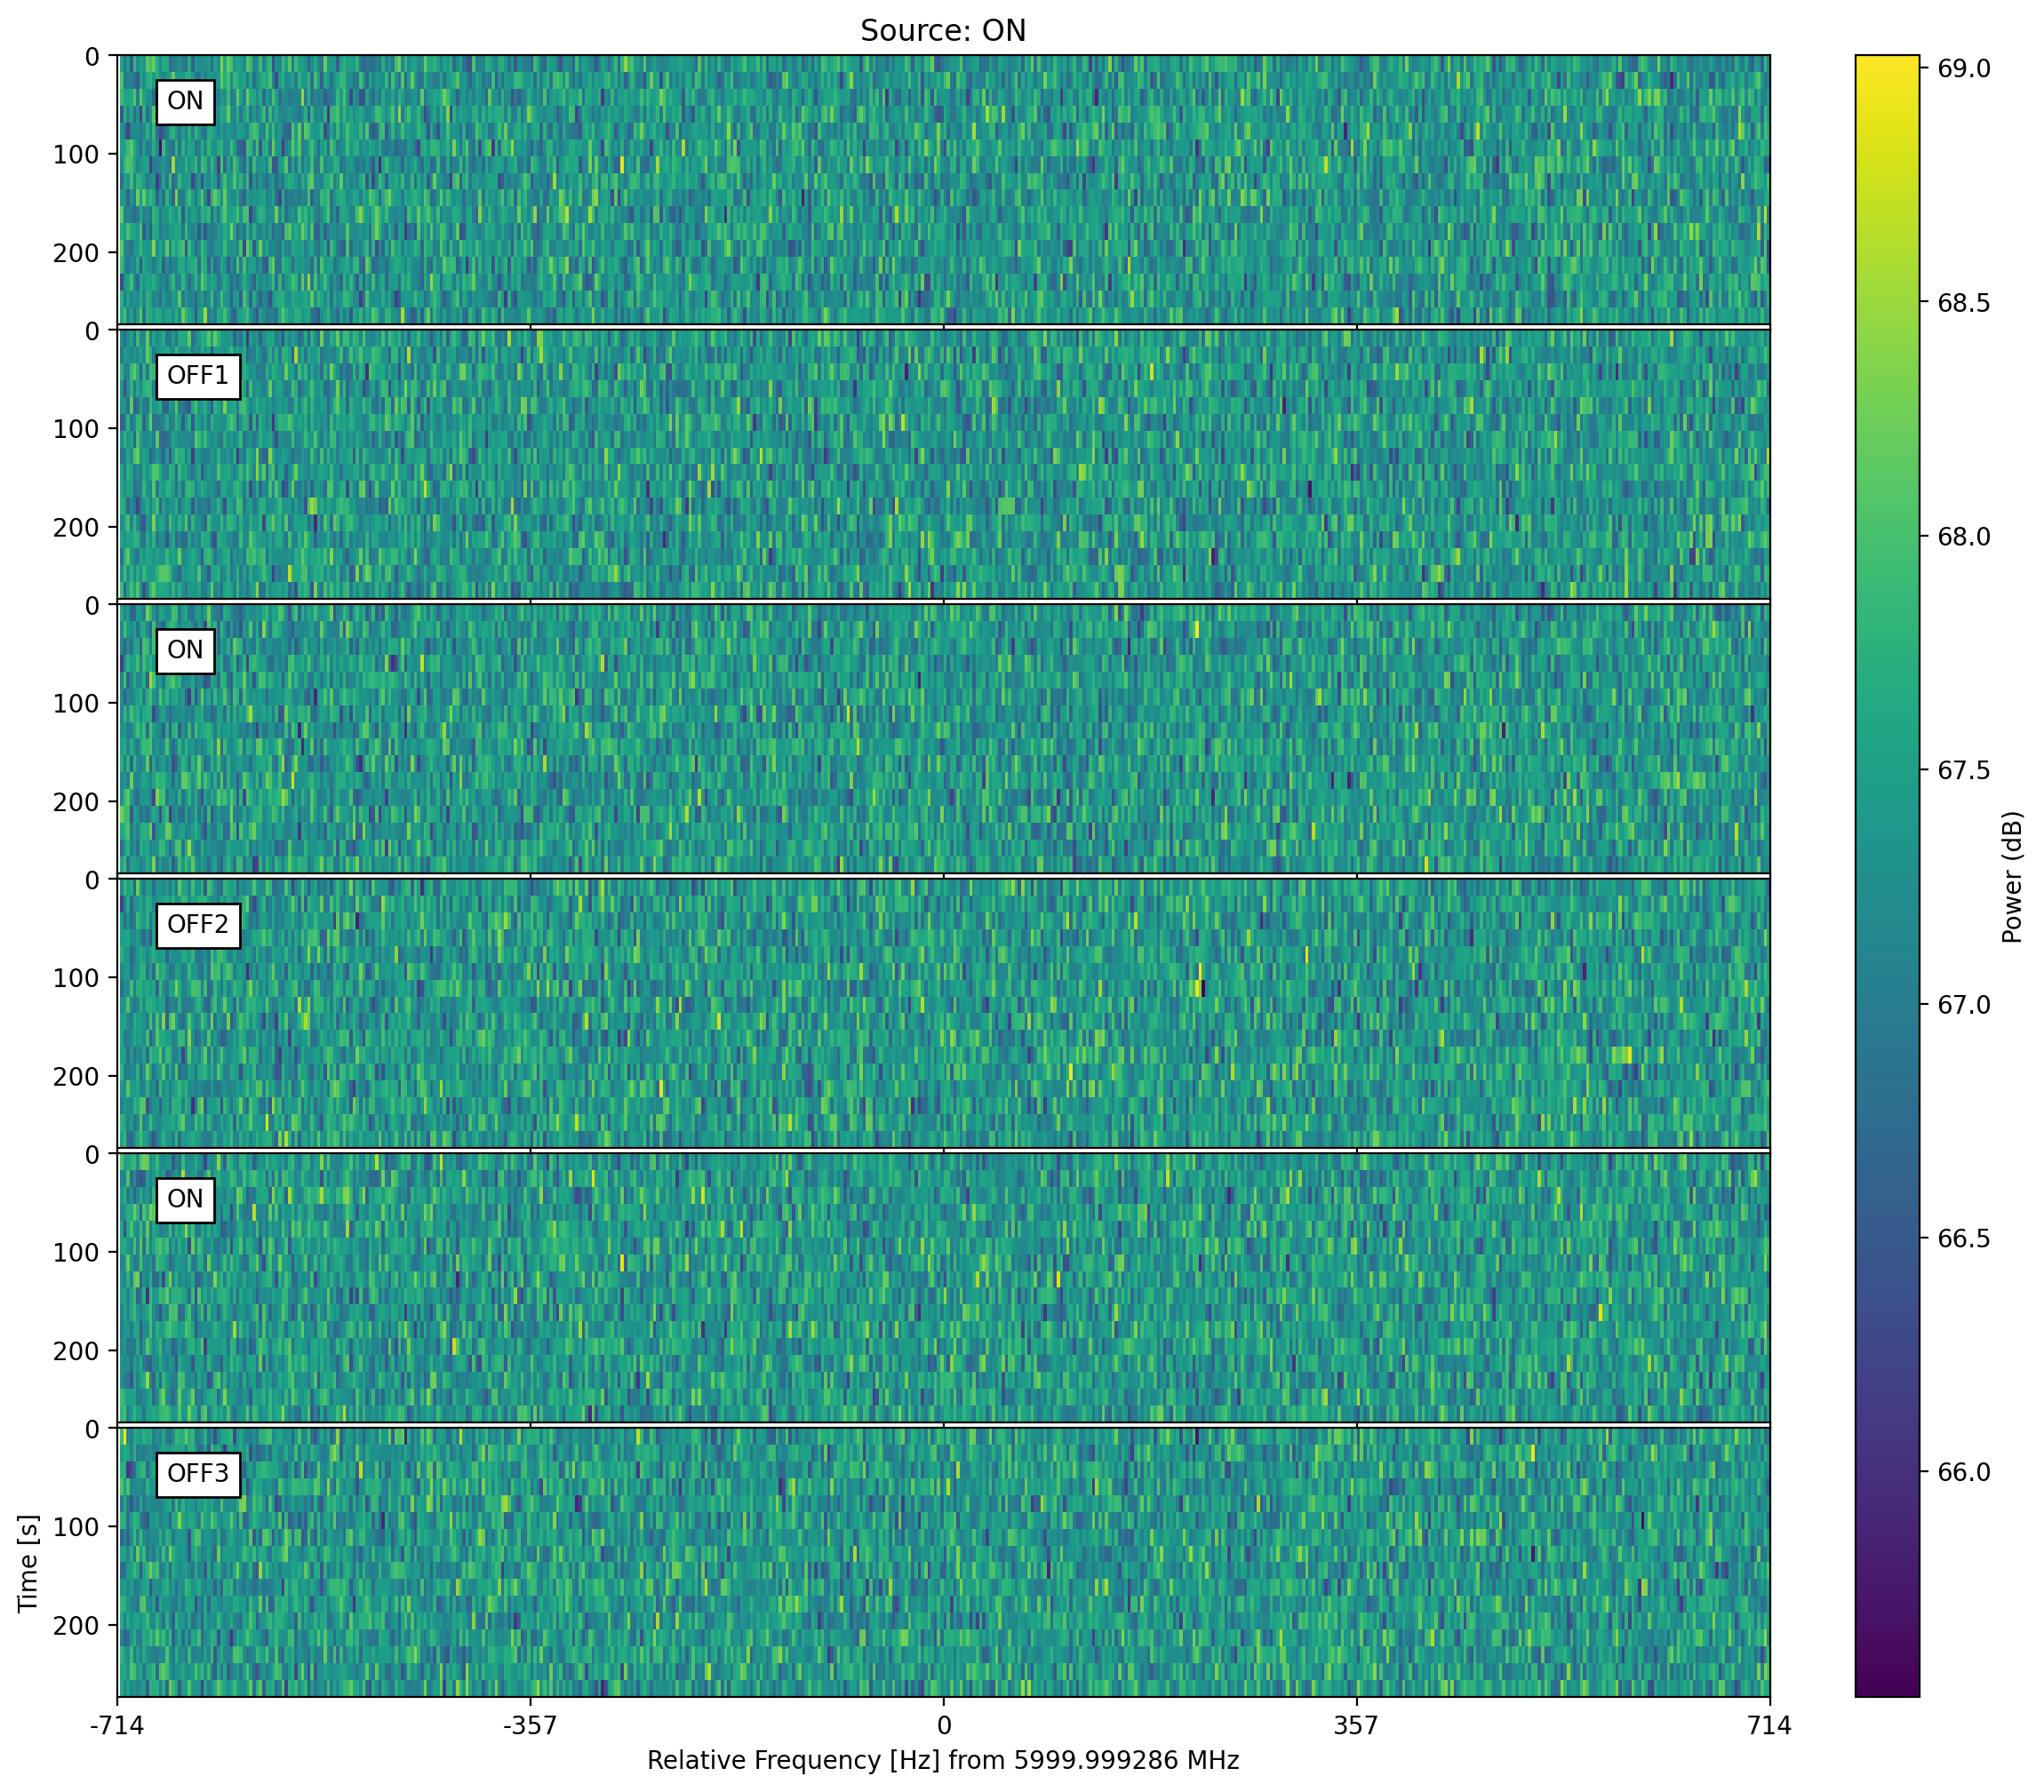

In [6]:
c.plot()
plt.show()

Of course, note that this is a simple, unphysical example that uses the same noise background for each pointing. 

We can now add an "RFI" signal to each frame:

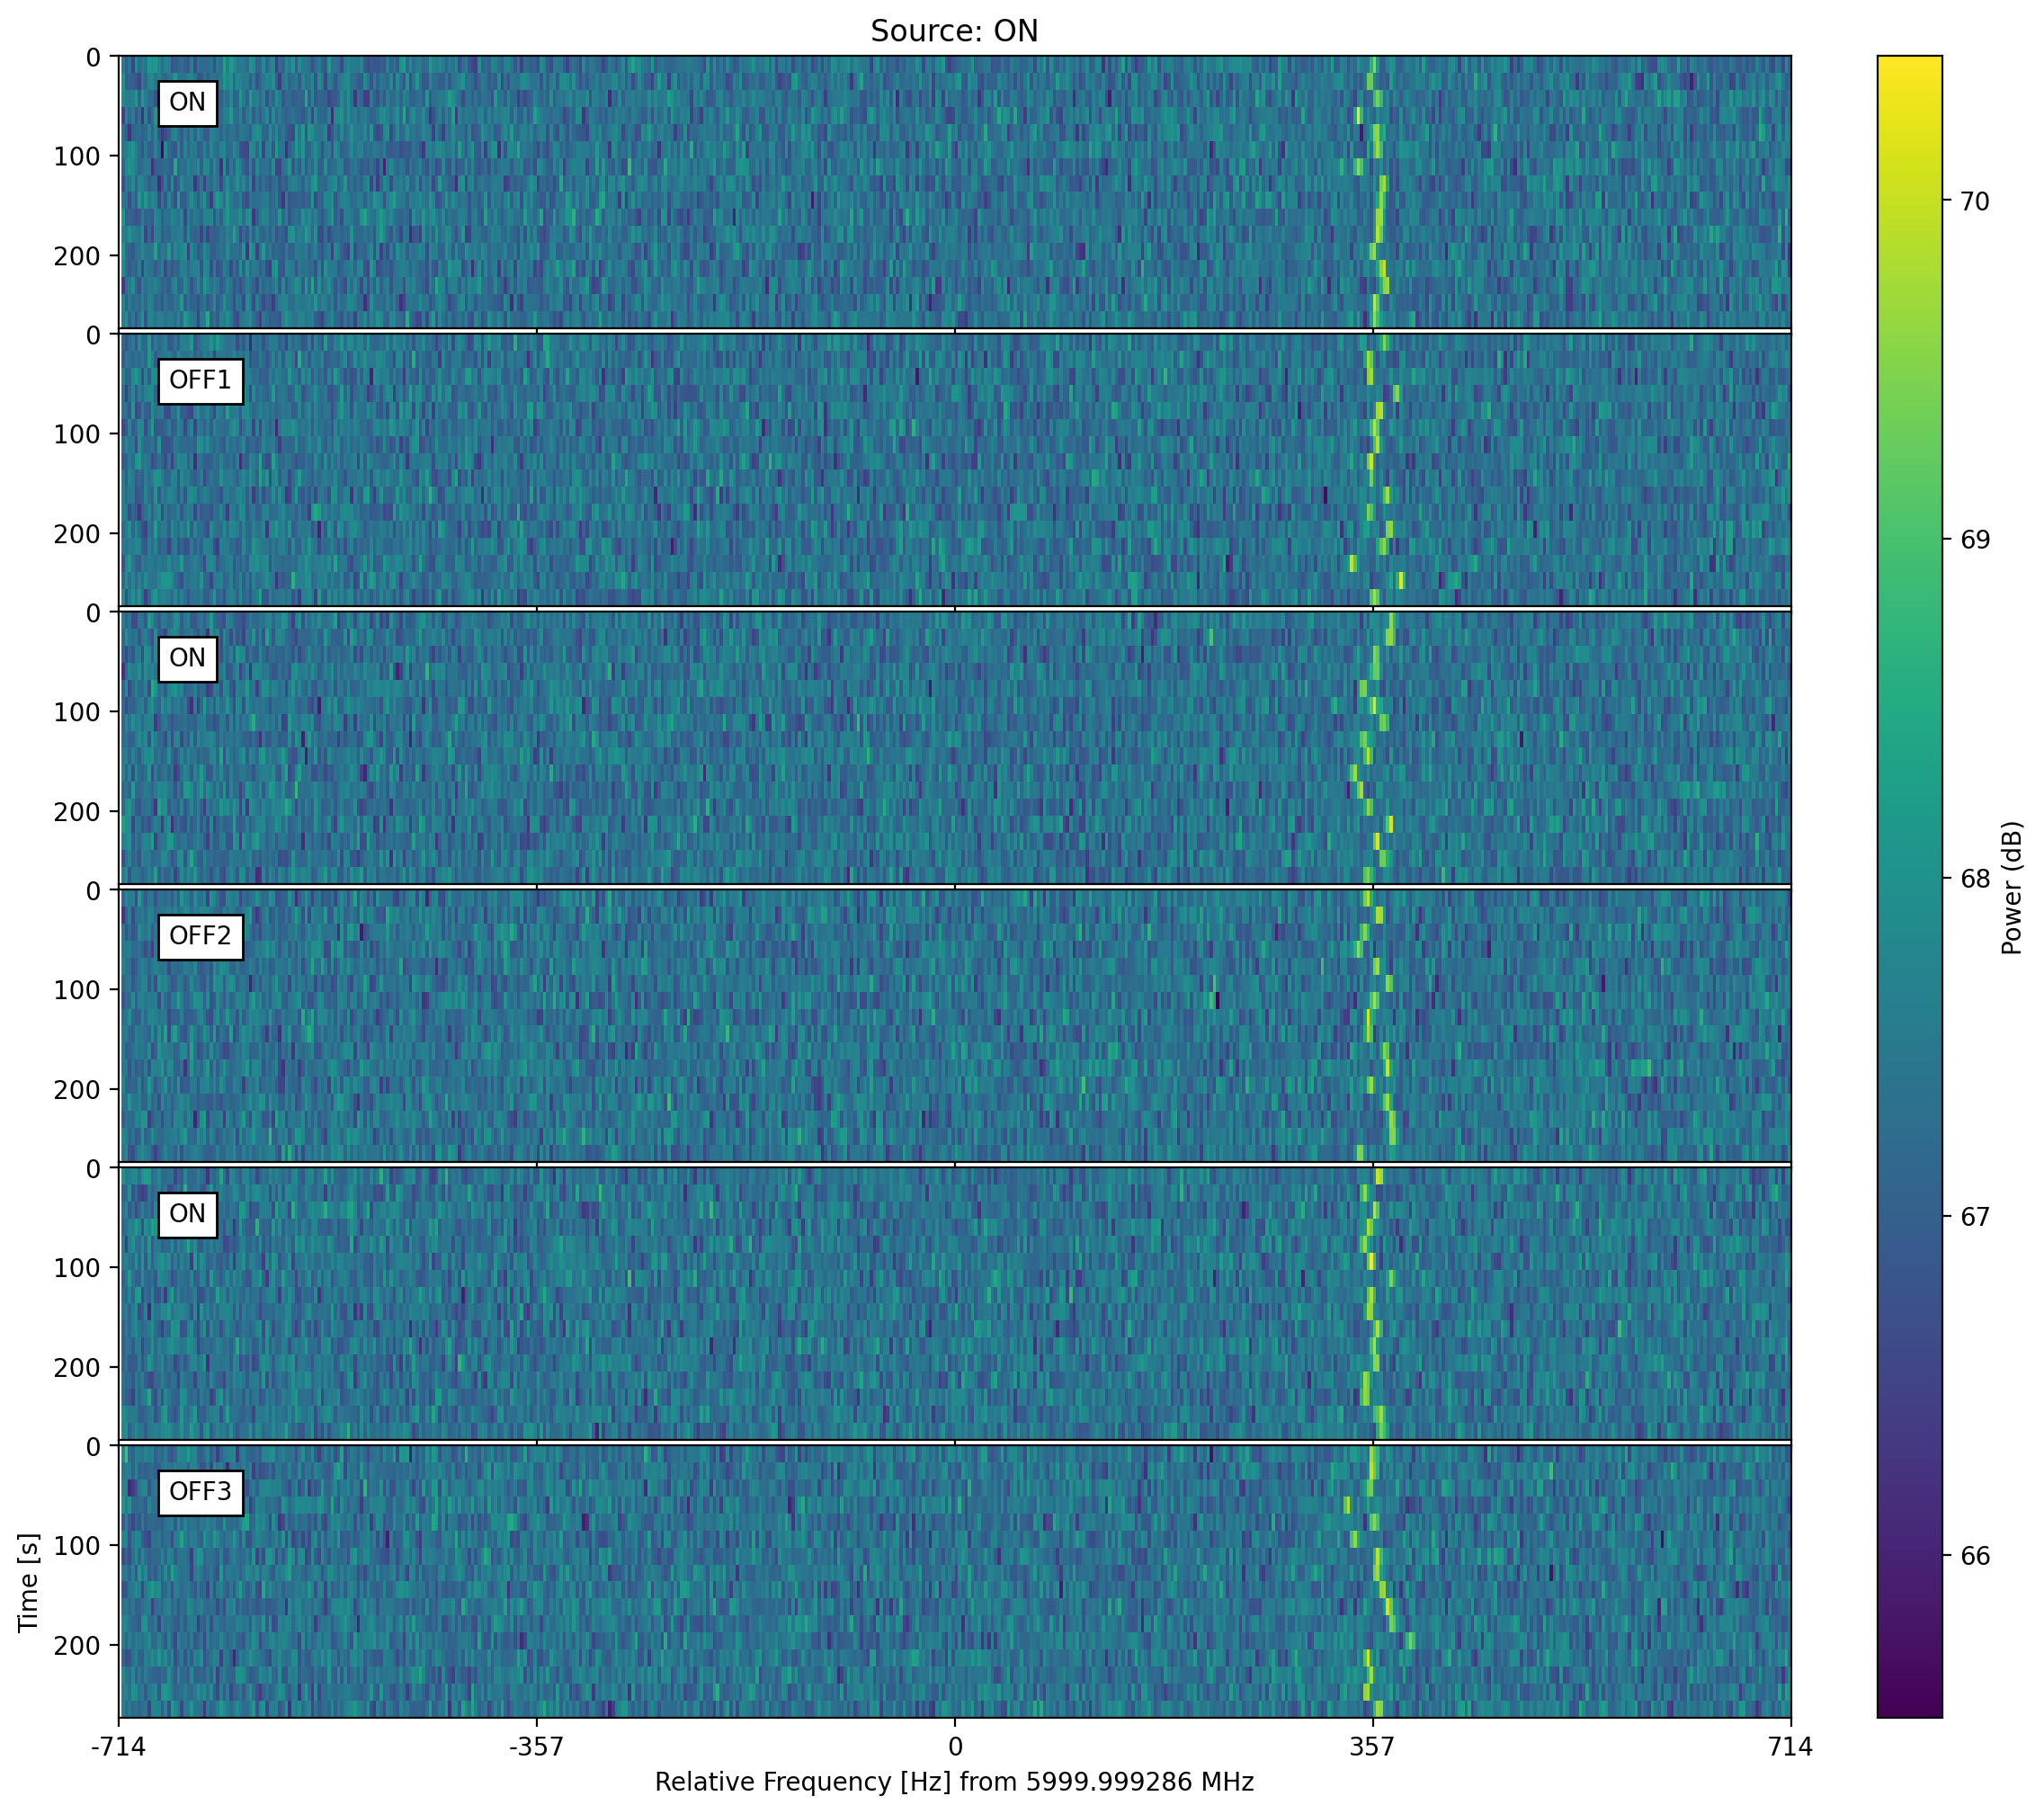

In [7]:
c.add_signal(stg.simple_rfi_path(f_start=c[0].get_frequency(index=384),
                                 drift_rate=0,
                                 spread=20*u.Hz,
                                 spread_type='normal',
                                 rfi_type='stationary'),
            stg.constant_t_profile(level=c[0].get_intensity(snr=30)),
            stg.sinc2_f_profile(width=2*c[0].df*u.Hz),
            stg.constant_bp_profile(level=1))
c.plot()
plt.show()

Now, we can add signals to only a few frames in the cadence, such as a "real" signal to only the ON observations. We can use either Python slices or arrays to specify which frames should have a signal injected. Here are a couple examples of this:

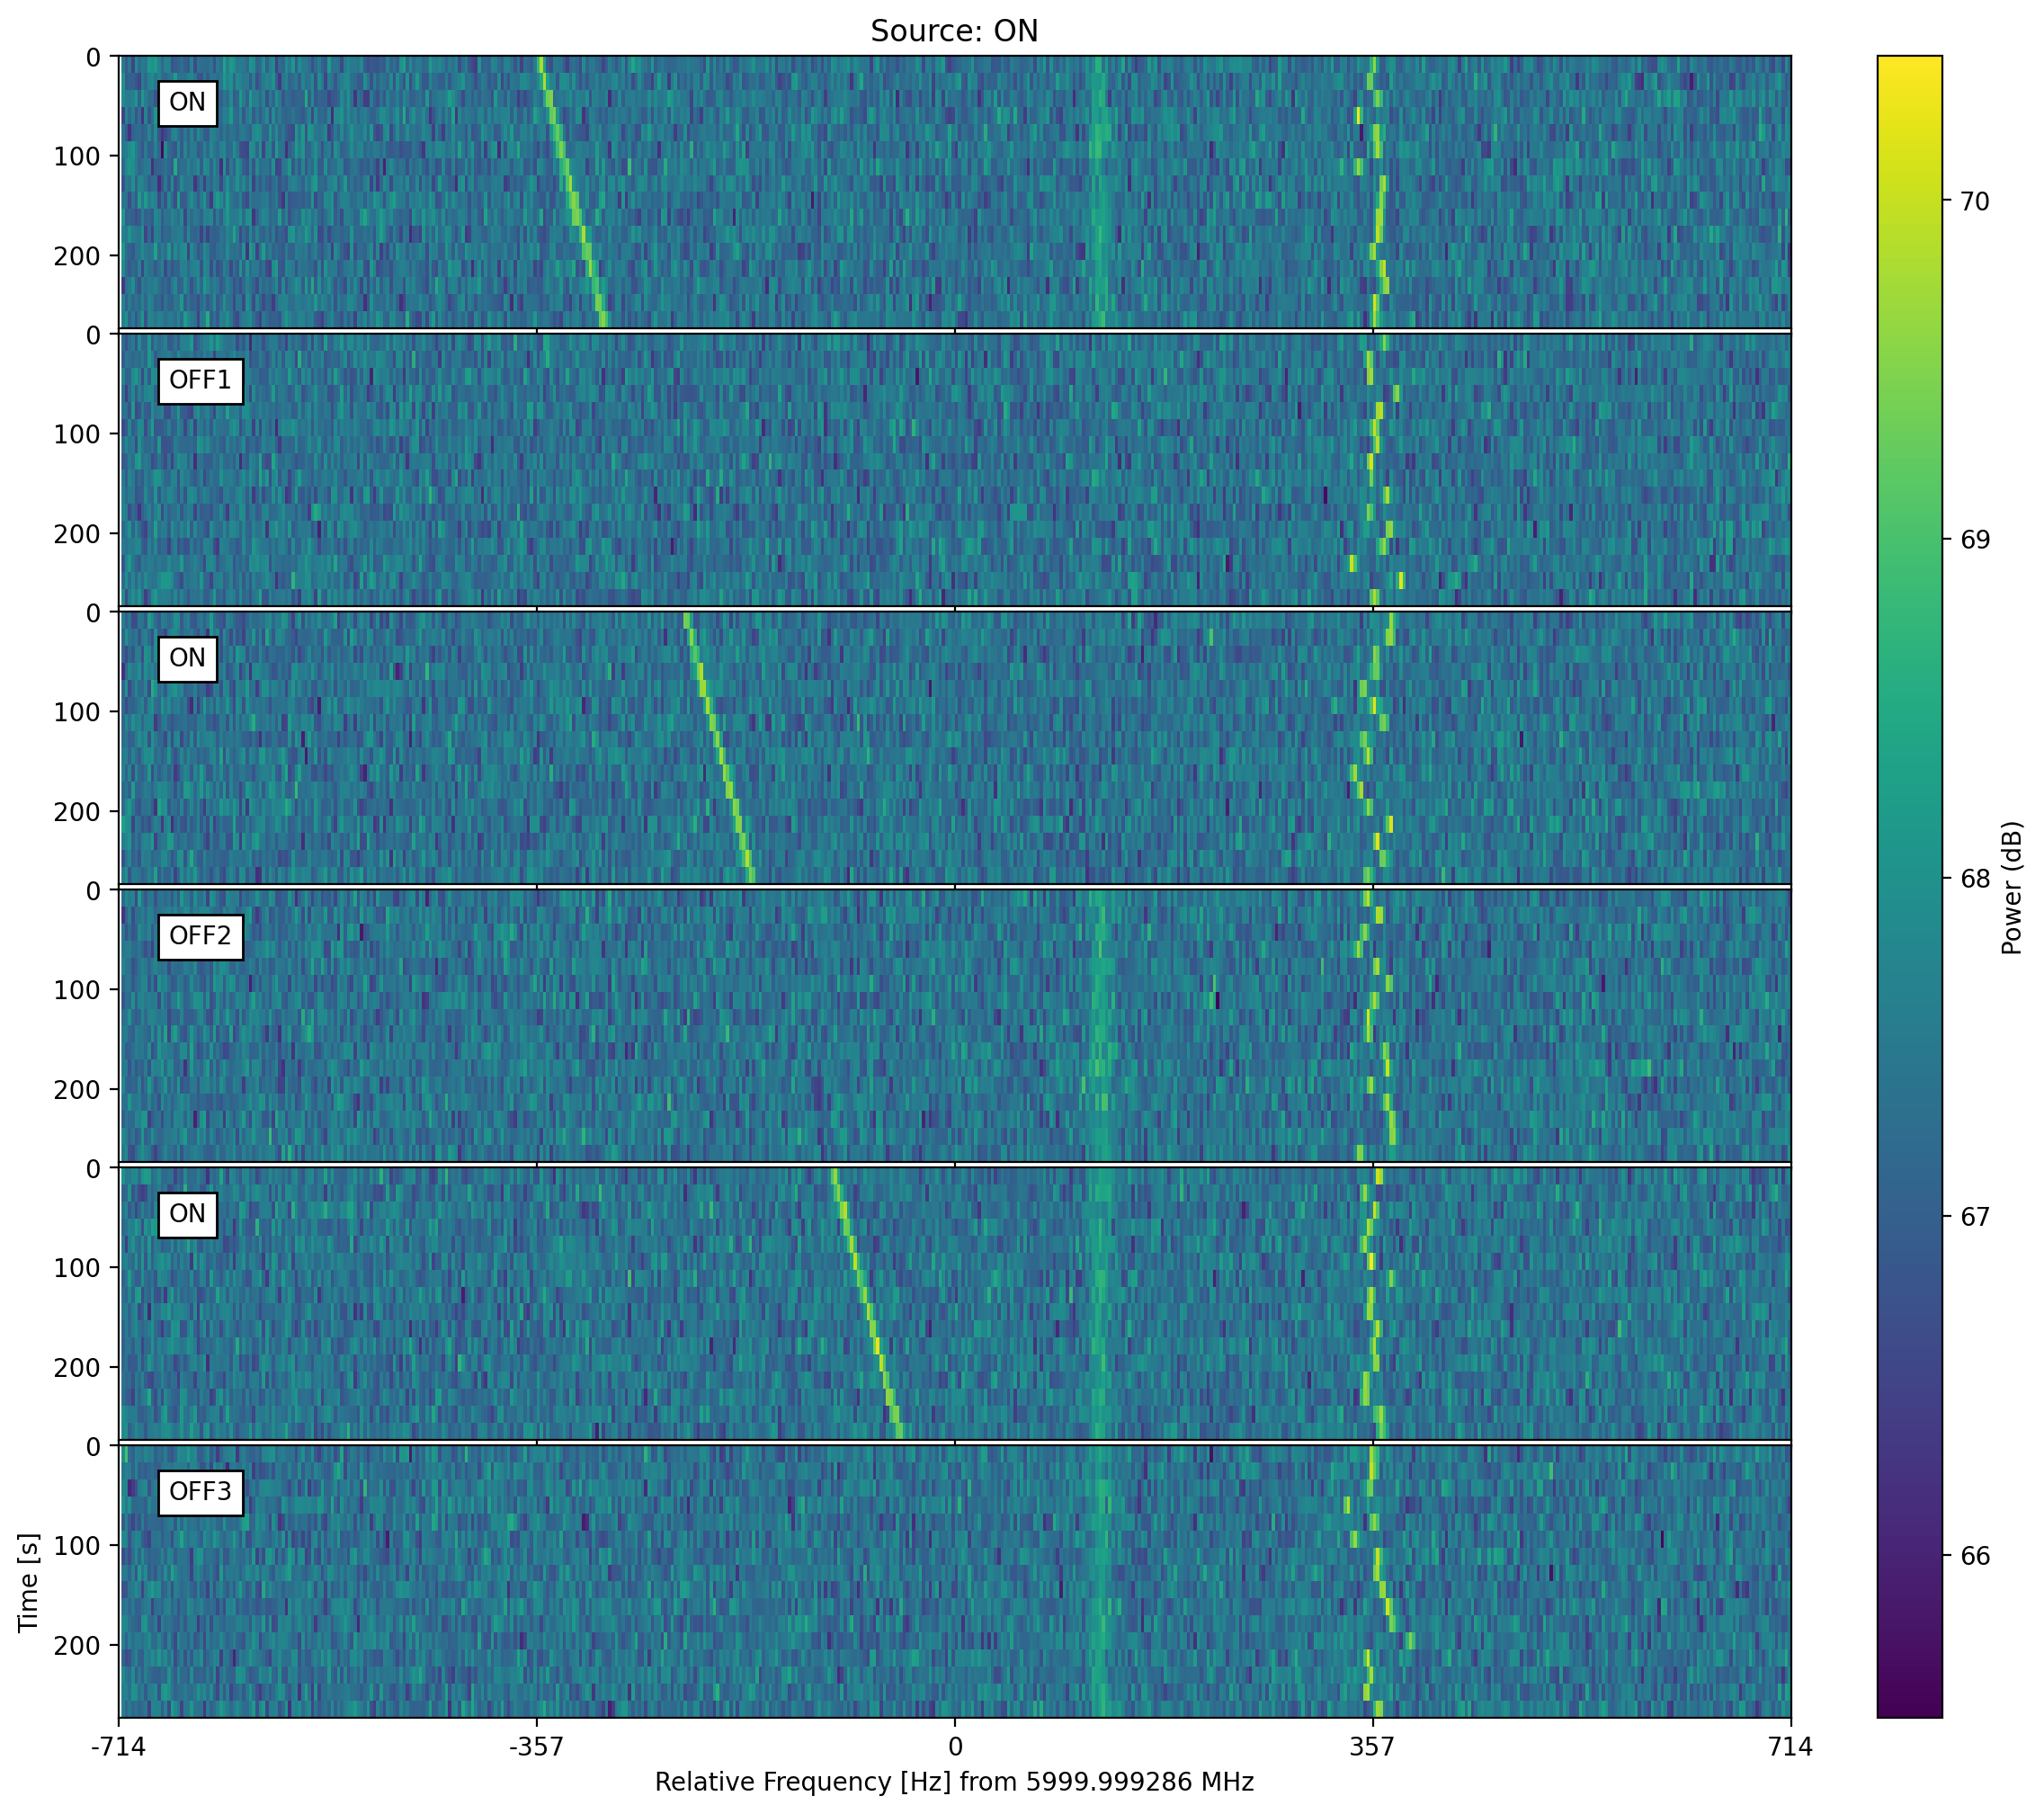

In [8]:
# Add a signal to only the ON frames
c[0::2].add_signal(stg.constant_path(f_start=c[0].get_frequency(index=128),
                      drift_rate=0.2*u.Hz/u.s),
            stg.constant_t_profile(level=c[0].get_intensity(snr=30)),
            stg.sinc2_f_profile(width=2*c[0].df*u.Hz),
            stg.constant_bp_profile(level=1),
            doppler_smearing=True)

# Add an "RFI" signal randomly to each frame with 2/3 probability
rfi_frames = np.random.rand(len(c)) < 2/3
c[rfi_frames].add_signal(stg.constant_path(f_start=c[0].get_frequency(index=300),
                      drift_rate=0),
            stg.constant_t_profile(level=c[0].get_intensity(snr=10)),
            stg.gaussian_f_profile(width=5*c[0].df*u.Hz),
            stg.constant_bp_profile(level=1),
            doppler_smearing=True)


c.plot()
plt.show()

Cadences also offer a function to stitch together each frame vertically, represented itself as a `Frame` object whose timestep array `ts` is similarly stitched from each component frame. 

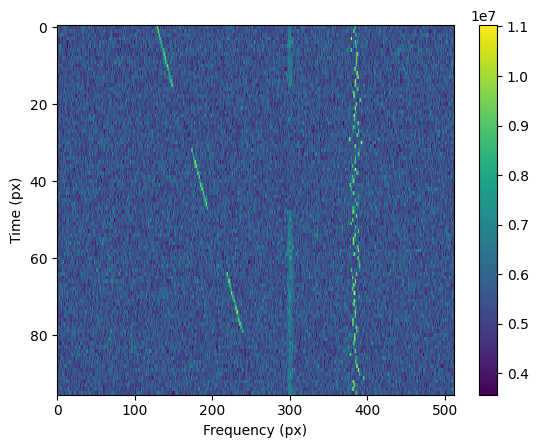

In [9]:
c_frame = c.consolidate()
c_frame.plot()
plt.show()